In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import sklearn
# fix random seed for reproducibility
np.random.seed(7)

from statsmodels.tsa.stattools import acf
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from xgboost import XGBRegressor

ROOT = "C:/Users/"

# MODELO CON XGBOOST

Este cuaderno va a tratar de aprovechar el método de árboles boostrapping de XGBoost. Este consistiría en esencia de árboles de decisiones que intentarían producir valores en función de las circunstancias en las que se encuentren los datos de entrada.

Los siguientes enlaces contienen guías que explican bien el método:

- https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

- https://www.datatechnotes.com/2019/06/regression-example-with-xgbregressor-in.html

In [2]:
# Función para el split.
def divide(df, proporcion = 0.75):
    corte = round(len(df)*proporcion)
    train = df[:corte]
    test = df[corte:]
    return train, test

# Métricas de performance.
def forecast_accuracy(forecast, actual):
    #=============================================================== AÑADIDO PARA DIFERENTES ARRAY
    if (len(forecast) != len(actual)):
        if (len(forecast) < len(actual)):
            actual = actual[:len(forecast)]
        else:
            forecast = forecast[:len(actual)]
    #===============================================================
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual)) # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual) / actual) # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]  # corr
    mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis = 1)
    maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis = 1)
    minmax = 1 - np.mean(mins / maxs)           # minmax
    acf1 = acf(forecast - actual)[1]            # autocorrelacion del error, primer lag
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 'corr':corr, 'minmax':minmax})

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis = 1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)
    return agg.values

# Crea un modelo XGBoost con los datos disponibles y realiza una predicción.
def xgboost_forecast(train, testX):
    # Transforma lista en array.
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainY = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective = 'reg:squarederror', learning_rate = 0.02, n_estimators = 1000)
    model.fit(trainX, trainY)
    # Realiza una sola predicción.
    forecast = model.predict(np.asarray([testX]))
    return forecast[0]

Función alternativa que permite realizar la validación completa del XGBoost. En este guión, el mismo proceso va a ser realizado de manera separada para facilitar la ilustración de cada procedimiento. No obstante, se mantiene planteada esta función ya que puede ser útil para un programador que desee emplearla directamente.

Código extraído del cuaderno del estudio de datos.

In [55]:
# los tres dataset
df_clientes = pd.read_csv(ROOT + ".csv", delimiter = ',')
df_dim_pedidos = pd.read_csv(ROOT + ".csv", delimiter = ',')
df_pedidos = pd.read_csv(ROOT + ".csv", delimiter = ',')
df_clientes = df_clientes.dropna()
df_dim_pedidos = df_dim_pedidos.dropna()
df_pedidos = df_pedidos.dropna()

# selecciona el id y la cantidad de pedidos en tabla auxiliar
df_aux = pd.DataFrame()
df_aux['cantidad'] = df_pedidos.groupby('digit_digit_sm_idpedido')['digit_digit_sm_cantidad'].sum()
df_aux = df_aux.reset_index() # groupby convierte la variable clave en index, por lo que hay que desconvertir

# crea un dataframe para unirlo todo
df = pd.DataFrame()
df['timestamp'] = pd.to_datetime(df_dim_pedidos['digit_digit_sm_fechapedido']) # extrae fechas
df = df[df['timestamp'] > '2015-01-01'] # a partir del año del comportamiento actual
#df = df[df['timestamp'] > '2012-01-01'] # a partir del año incluyendo la crisis del 2008
#df = df[df['timestamp'] < '2021-06-01'] # omitiendo los picos de ventas post-covid
df['id_pedido'] = df_dim_pedidos['digit_digit_sm_idpedido'] # extrae id para añadir la informacion del pedido
df = df.join(df_aux.set_index('digit_digit_sm_idpedido'), on = 'id_pedido') # añade informacion de pedido
df = df.drop(['id_pedido'], axis = 1) # elimina la columna auxiliar de los pedidos
df = df.sort_values(by = 'timestamp', ascending = True) # ordena segun el timestamp
df['week'] = df['timestamp'].dt.isocalendar().week # una columna con la semana del año
df['year'] = df['timestamp'].dt.year # una columna por año
df = df.set_index(['week', 'year']) # establece semanas y años de index para agrupar segun ellos
df['cantidad'] = df.groupby(['week', 'year'])['cantidad'].sum() # agrupa los pedidos que se produjeron la misma semana del año
df = df[~ df.index.duplicated(keep = 'first')] # elimina las replicas que se han producido en la agrupacion anterior
df = df.reset_index().set_index(['timestamp']) # cambia timestamp de index
df = df.drop(['week', 'year'], axis = 1) # elimina las columnas innecesarias
df['cantidad'] = df['cantidad'].rolling(1, center = True, closed = 'both').mean() # suavizado mediante Moving Average
# elimina nan
print(df.shape)
df = df.dropna()
print(df.shape)

# elimina negativos y ceros para poder aplicar seasonal
df = df[df['cantidad'] > 0]
df

(362, 1)
(362, 1)


,cantidad
timestamp,
2015-01-02,4665.0
2015-01-06,9749.0
2015-01-12,13518.0
2015-01-19,12178.5
2015-01-26,11241.5
...,...
2021-11-01,10442.0
2021-11-10,6107.0
2021-12-01,16609.5


# =============================================================

### Implementación de XGBoost mediante aprendizaje supervisado

Al igual que lo que pasará posteriormente con las redes neuronales, estos algoritmos necesitan recibir directamente los datos de estudio en forma de input, de forma que se tiene que decidir que cantidad de lags en el pasado sería conveniente revisar. En el estudio de datos se pudo preveer que en este dataset, los datos que más influyen en el estado anterior son como mucho los dos primeros. Sin embargo, ya que esto es una prueba, se van a proponer más, siendo declarados en la variable look_back.

In [4]:
look_back = 6

XGBoost requiere que los datos sean un array.

series_to_supervised también será empleado en el notebook de las redes neuronales. Es una función que genera una tabla en la que cada punto de la grafica tiene como inputs los **n = look_back** valores anteriores, que son los valores que van a explicar dicho punto.

In [5]:
# XGBoost requiere de arrays.
dataset = df.values
# Matriz de lags previos con el lag principal.
dataset = series_to_supervised(dataset, n_in = look_back)
# El valor real TRANSPUESTO del dataset.
datasetY = dataset[:, -1]

Igual que siempre, los datos deben separarse de forma ordenada, sin ser mezclados.

In [6]:
train, test = divide(dataset, proporcion = 0.95)

Se crea un vector **forecast_list**, paralelo al test en el que se almacenarán las predicciones. Se crea también un array de arrays llamado **history** que servirá para realizar las propias predicciones, haciendo que el modelo sea predicho no por los datos predichos, sino por los datos ideales.

In [7]:
# step over each timestep in the test set
forecast_list = np.full((len(test)), np.nan)
# seed history with training dataset
history = [x for x in train]

En cada iteración se entrenaría supervisadamente un nuevo modelo más actualizado y se realizaría la predicción del punto nuevo (una semana en el futuro).

In [8]:
for i in range(len(test)):
    # Actualiza el modelo y realiza la predicción. Almacena la predicción.
    forecast_list[i] = xgboost_forecast(history, test[i, :-1])
    # Añade la observación para el siguiente ciclo.
    history.append(test[i])

Obtención de estadísticos. El paso previo los coloca en el formato necesario para poder ser comparados.

In [9]:
# el valor real del test
testY = test[:, -1]
forecast_accuracy(forecast_list, testY)

D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'mape': 0.8951342183239402,
 'me': -1553.3400065104167,
 'mae': 8296.621365017361,
 'mpe': 0.6074022378404128,
 'rmse': 12087.159269674097,
 'acf1': 0.1735070981370388,
 'corr': 0.5025512800489856,
 'minmax': 0.32760819071650893}

Se desplazan los datos predichos. Además se tienen que desplazar los datos de predicción del test hasta despues del train.

In [10]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(datasetY)
testPredictPlot[:] = np.nan
# En este caso los datos de predicción tienen que estar desplazados teniendo en cuenta que antes está el train.
testPredictPlot[len(train):len(dataset) + 1] = forecast_list

Representación de la predicción final.

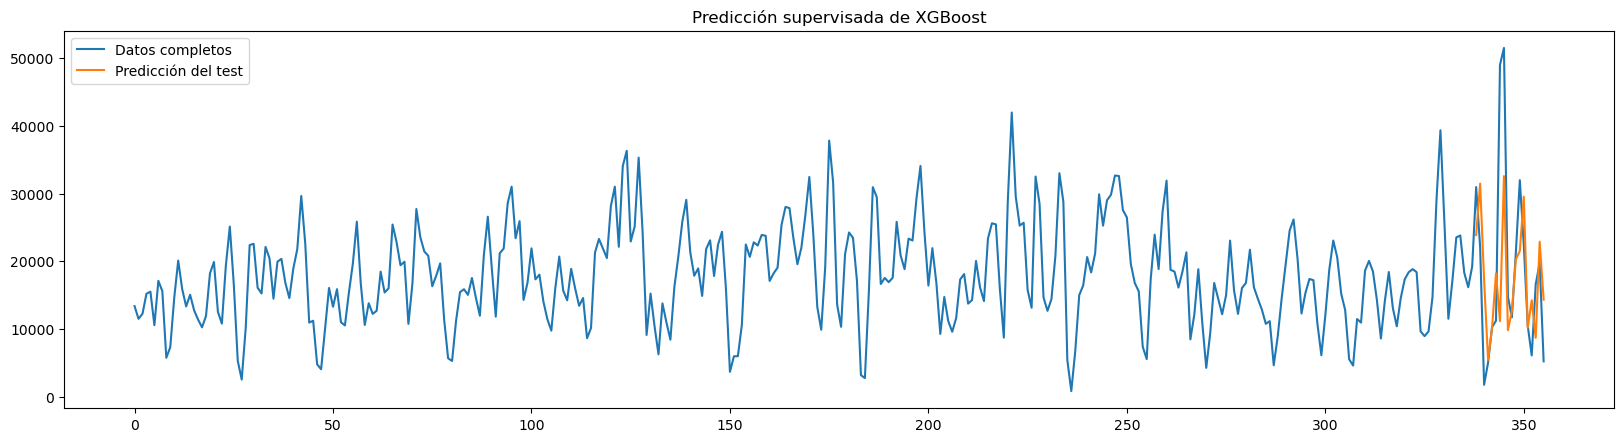

In [11]:
# plot baseline and predictions
plt.figure(figsize = (20, 5), dpi = 100)
plt.plot(datasetY, label = 'Datos completos')
plt.plot(testPredictPlot, label = 'Predicción del test')
plt.title('Predicción supervisada de XGBoost')
plt.legend(loc = 'upper left', fontsize = 10)
plt.show()

# =============================================================

### Predicción de algunas semanas en el futuro mediante modelo estático

Añadido al estudio supervisado, se propone la predicción futura de semanas en adelante para comprobar cuan preciso sería el modelo en el largo plazo. La premisa del look_back va a ser mantenida.

In [12]:
look_back = 6

Datos divididos de nuevo junto con la declaración del array de predicciones. En este caso el procedimiento será distinto pues no se creará una matriz para la predicción de datos anteriores sino que simplemente se consultarán del mismo vector forecast_list.

In [13]:
dataset = df.values
train, test = divide(dataset, proporcion = 0.95)
forecast_list = np.reshape(train[-look_back:], look_back)

Lo que sí será cambiado a matriz de lags previos son los del entrenamiento para simplificar la creación del modelo regresor.

In [14]:
# Crea la matriz de datos previos como predictores.
trainXY = series_to_supervised(train, n_in = look_back)
# Se adaptan los datos al formato para entrenamiento de train y outcome.
trainX, trainY = trainXY[:, :-1], trainXY[:, -1]
# Fit model con los datos adaptados.
model = XGBRegressor(objective = 'reg:squarederror', learning_rate = 0.02, n_estimators = 1000)
model.fit(trainX, trainY)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

Se proponen una serie de evaluadores de la calidad del modelo, siendo el primero uno implementado por la propia librería. Donde la calidad de predicción de sus propios datos de train resulta evidentemente buena. Este no sería un evaluador apropiado del desempeño del modelo.

In [15]:
score = model.score(trainX, trainY)  
print("Training score: ", score)

Training score:  0.998810585398515


Uno a priori mejor sería el método **Cross-Validation** que separa aleatoriamente los datos de entrenamiento en diferentes subsets o "folds", comparando así la predicción de dichos subsets de manera desordenada y superponiendo muestras.

Este método no revela una gran media de desempeño debido a la necesidad de las series temporales de establecer el orden delos datos para mantener la coherencia en la predicción.

In [16]:
scores = cross_val_score(model, trainX, trainY, cv = 10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.21


La opción que razonablemente mejores resultados da se trata del **K-folds Cross-Validation**. Consistiendo esta en la separación ordenada (shuffle = False) de los datos en una cantidad "k" de segmentos o "folds" para el entrenamiento, menos uno, siendo este para la validación. Este caso reveló un mejor desempeño debido a que si que tiene en cuenta el orden, siendo así más coherente con las necesidades de las series temporales.

In [17]:
kfold = KFold(n_splits = 10, shuffle = False)
kf_cv_scores = cross_val_score(model, trainX, trainY, cv = kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.21


Este bucle va a realizar una predicción contínua empleando los datos del vector forecast_list a la vez que lo enriquecen. Cada iteración añadirá su propia predicción al vector mediante append, que luego será empleada para la consecuente predicción.

In [18]:
for i in range(len(test)):
    prediction = model.predict(np.asarray([forecast_list[-look_back:]]))
    forecast_list = np.append(forecast_list, prediction)

Se pasan los datos del test al formato vector para poder ser evaluados con los de la predicción.

In [19]:
test = np.reshape(test, len(test))

El modelo resultante ha empeorado su desempeño como se aprecia a continuación, donde antes había una correlación del 57 %, ahora ha caido al 38 %. Y el RMSE ha aumentado de 11435 a 13734.

In [20]:
forecast_accuracy(forecast_list[look_back:], test)

D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'mape': 1.2074991345657873,
 'me': -1484.8004014756943,
 'mae': 9958.62841796875,
 'mpe': 0.8972050915518768,
 'rmse': 13478.109068729858,
 'acf1': 0.38271613313276437,
 'corr': 0.24493156798123855,
 'minmax': 0.3914985699380933}

La predicción muestra como estos datos han empeorado drásticamente en predicciones más alejadas de la segunda semana. El error se ha ido acumulando y, dada la naturaleza de los árboles de decisiones a ser susceptibles a modificar su respuesta en función de la situación en la que se encuentre, es probable que sean más susceptibles a esta acumulación de error que una regresión normal.

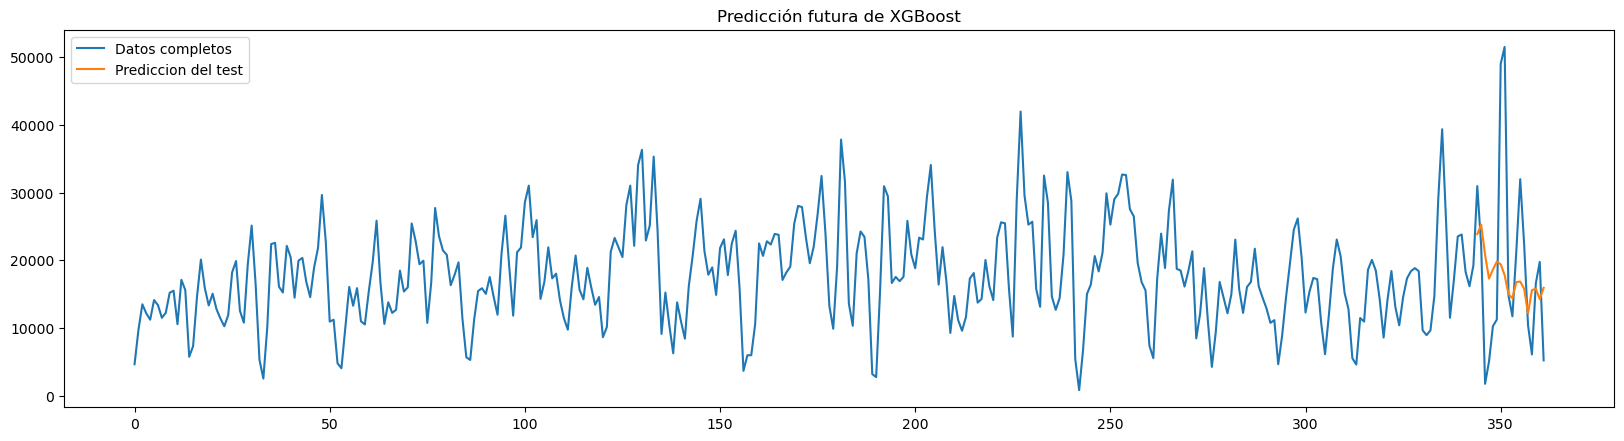

In [21]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset[:, -1])
testPredictPlot[:] = np.nan
# En este caso los datos de predicción tienen que estar desplazados teniendo en cuenta que antes está el train.
testPredictPlot[len(train):len(dataset) + 1] = forecast_list[look_back:]
# plot baseline and predictions
plt.figure(figsize = (20, 5), dpi = 100)
plt.plot(dataset[:, -1], label = 'Datos completos')
plt.plot(testPredictPlot, label = 'Prediccion del test')
plt.title('Predicción futura de XGBoost')
plt.legend(loc = 'upper left', fontsize = 10)
plt.show()

# =============================================================

### Mejora y optimización del modelo mediante Grid Search

Dado que el algoritmo de árboles es altamente personalizable, se propone la prueba de una matriz de mejoras que permiten la optimización de varios de estos parámetros.

El estudio de los hiperparámetros de mejora del modelo:

- https://www.kaggle.com/code/amneves/xgboost-regressor-with-random-search-hypertuning/notebook

Un ejemplo de creación de grids para optimización:

- https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost/notebook

In [22]:
look_back = 6

Preparación de los datos al igual que antes, solo que en este caso no se realiza el "fit directo" del modelo, sino que ocurriría un paso intermedio en el que se buscaría la opción de hiperparámetros mejor adaptada a la predicción del set.

In [23]:
dataset = df.values
train, test = divide(dataset, proporcion = 0.95)
forecast_list = np.reshape(train[-look_back:], look_back)
# Crea la matriz de datos previos como predictores.
trainXY = series_to_supervised(train, n_in = look_back)
# Se adaptan los datos al formato para entrenamiento de train y outcome.
trainX, trainY = trainXY[:, :-1], trainXY[:, -1]
# Fit model con los datos adaptados.
model = XGBRegressor(objective = 'reg:squarederror', learning_rate = 0.02, n_estimators = 1000, nthread = -1)#, early_stopping_rounds = 10

Esta sería la declaración de los hiperparámetros principales más comunmente empleados para XGBoost junto con los rangos de estudio propuestos. En realidad existen varios más, pero estos serían más que suficientes para comprobar cuanto se podría mejorar la predicción.

In [24]:
# El grid de parámetros.
params = {'learning_rate' : [i/10.0 for i in range(3, 8)], # (eta) Controla el ratio de aprendizaje del algoritmo.
          'min_child_weight': [i for i in range(3, 11)], # Indica el valor mínimo de la suma de los pesos en cada nodo. Previene overfitting.
          'gamma': [i/2.0 for i in range(1, 11)], # Indica el valor mínimo de loss para producir una nueva separacion de nodos, estableciendo lo conservativo del modelo. 
          'subsample': [i/10.0 for i in range(6, 11)], # Determina la fracción de datos que van a ser empleados para cada árbol. Previene overfitting.
          'colsample_bytree': [i/10.0 for i in range(6, 11)], # Ratio de submuestras por columna cuando se construye cada árbol.
          'objective': ['reg:squarederror', 'reg:tweedie'],
          'max_depth': [3, 4, 5, 6]} # Controla la profundidad máxima del arbol. Previene overfitting.

Finalmente se declara el modelo con los hiperparámetros definidos y el estadístico de estudio.

In [25]:
random_search = RandomizedSearchCV(model, 
                                   param_distributions = params, 
                                   n_iter = 5,
                                   scoring = 'neg_mean_squared_error',
                                   cv = 5,
                                   verbose = 1)

Y ahora si que se genera el modelo, pero el obtenido de la optimización de los hiperparámetros.

In [26]:
random_search.fit(trainX, trainY)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.02, max_bin=None,
                                          m...
                                          reg_alpha=None, ...),
                   n_iter=5,
             

Ya que el objetivo de este apartado es el de mejorar el desempeño del modelo base, RandomizedSearchCV dispone de la posibilidad de seleccionar el modelo que mejores resultados produjo respecto del estadístico de estudio.

In [27]:
best_regressor = random_search.best_estimator_

Cuando se estudia la Cross-Validation, esta parece tener un desempeño más variante respecto del modelo básico sin optimizar. Todavía se debe contrastar este evaluador interno con los otros parámetros estadísticos.

In [28]:
kfold = KFold(n_splits = 10, shuffle = False)
kf_cv_scores = cross_val_score(best_regressor, trainX, trainY, cv = kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.21


Al igual que antes, se progresa en las predicciones a través de las anteriores, pero siempre usando el mismo modelo fijo.

In [29]:
for i in range(len(test)):
    prediction = best_regressor.predict(np.asarray([forecast_list[-look_back:]]))
    forecast_list = np.append(forecast_list, prediction)

El desempeño del modelo más óptimo suele variar cada vez que se ejecuta este código. Siendo así que el RMSE puede acabar siendo mejor o peor que el original de 13478.

In [30]:
test = np.reshape(test, len(test))
forecast_accuracy(forecast_list[look_back:], test)

D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'mape': 0.9340404473223514,
 'me': 1022.5087076822916,
 'mae': 9860.832058376736,
 'mpe': 0.7162470732523226,
 'rmse': 12510.025031791301,
 'acf1': 0.2835204421623739,
 'corr': 0.4331073969245184,
 'minmax': 0.4017730982201063}

Es importante aclarar que, si bien la optimización es un método muy útil, en este caso se requeriría un estudio más profundo de los hiperparámetros para que puedan mejorar el proceso y no empeorarlo como ha acabado ocurriendo.

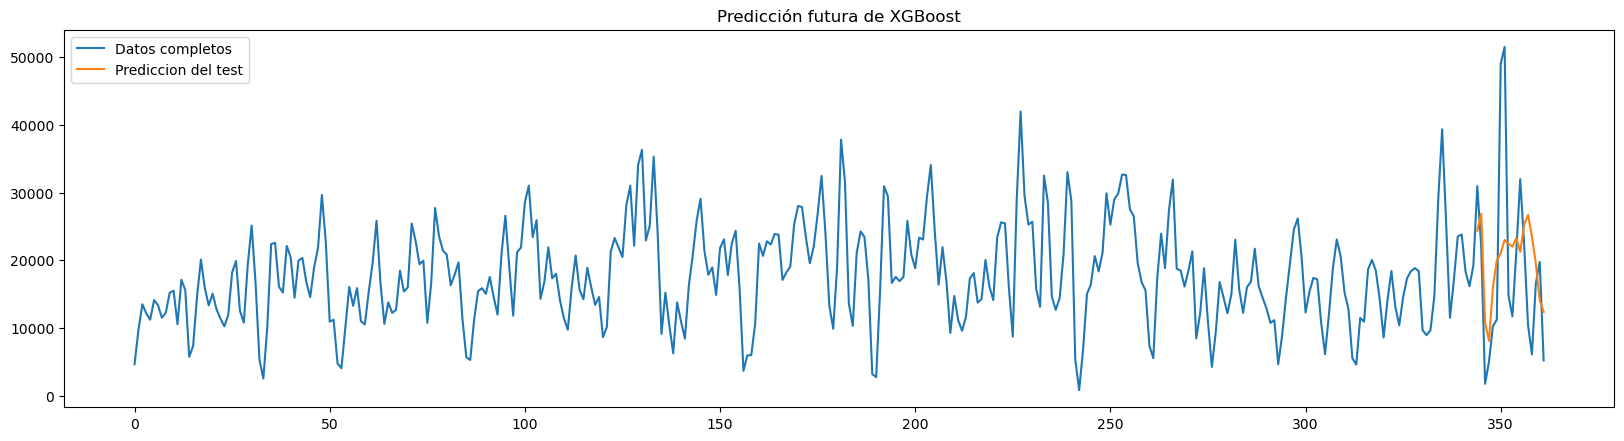

In [31]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset[:, -1])
testPredictPlot[:] = np.nan
# En este caso los datos de predicción tienen que estar desplazados teniendo en cuenta que antes está el train.
testPredictPlot[len(train):len(dataset) + 1] = forecast_list[look_back:]
# plot baseline and predictions
plt.figure(figsize = (20, 5), dpi = 100)
plt.plot(dataset[:, -1], label = 'Datos completos')
plt.plot(testPredictPlot, label = 'Prediccion del test')
plt.title('Predicción futura de XGBoost')
plt.legend(loc = 'upper left', fontsize = 10)
plt.show()

# =============================================================

### Predicción de algunas semanas en el futuro mediante modelo dinámico

Una mejora del modelo anterior sería no quedarse en el empleo del modelo entrenado con los datos del train, sino actualizarlo con los datos de la misma predicción, añadiendo este entrenamiento al bucle de predicciones. Además se propone la optimización opcional, aunque esta probocaría que el entrenamiento se ralentizara enormemente.

In [64]:
look_back = 6
# Cambiar "optimizar" a true para optimizar el modelo.
optimizar = True

Se repite el mismo proceso en el que se separan ordenadamente los datos y se crea una matriz de valores previos del train para el entrenamiento del modelo.

In [65]:
dataset = df.values
train, test = divide(dataset, proporcion = 0.95)
forecast_list = np.reshape(train[-look_back:], look_back)
# Crea la matriz de datos previos como predictores.
trainXY = series_to_supervised(train, n_in = look_back)
# Se adaptan los datos al formato para entrenamiento de train y outcome.
trainX, trainY = trainXY[:, :-1], trainXY[:, -1]
# Fit model con los datos adaptados.
model = XGBRegressor(objective = 'reg:squarederror', learning_rate = 0.02, n_estimators = 1000, verbosity = 0)
model.fit(trainX, trainY)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

Ya que se va a expandir el mismo train siendo este enriquecido por los datos de la predicción, se debe recuperar su tamaño original para poder ser empleado posteriormente. **Este paso es importante para la representación**.

In [66]:
train_len = len(train)

En ese apartado se ha ofrecido la posibilidad de optimizar el procedimiento como ya se ha mostrado anteriormente. Que se prepare o no el grid para optimizar depende de una variable lógica declarada al principio del apartado junto con la declaración del look_back.

In [67]:
if (optimizar):
    params = {'learning_rate' : [i/10.0 for i in range(3, 8)], # (eta) Controla el ratio de aprendizaje del algoritmo.
              'min_child_weight': [i for i in range(3, 11)], # Indica el valor mínimo de la suma de los pesos en cada nodo. Previene overfitting.
              'gamma': [i/2.0 for i in range(1, 11)], # Indica el valor mínimo de loss para producir una nueva separacion de nodos, estableciendo lo conservativo del modelo. 
              'subsample': [i/10.0 for i in range(6, 11)], # Determina la fracción de datos que van a ser empleados para cada árbol. Previene overfitting.
              'colsample_bytree': [i/10.0 for i in range(6, 11)], # Ratio de submuestras por columna cuando se construye cada árbol.
              'objective': ['reg:squarederror', 'reg:tweedie'],
              'max_depth': [3, 4, 5, 6]} # Controla la profundidad máxima del arbol. Previene overfitting.
    random_search = RandomizedSearchCV(model, 
                                       param_distributions = params, 
                                       n_iter = 5,
                                       scoring = 'neg_mean_squared_error',
                                       cv = 5)
    random_search.fit(trainX, trainY)
    model = random_search.best_estimator_ # El modelo que va a entrar en el bucle ya está optimizado.

- La clave de este procedimiento se encuentra en el bucle en el que se mantiene la predicción anterior de enriquecimiento de forecast_list. En este caso, esta predicción no solo se añadiría al vector de predicciones sino también al mismo train. Cada vez que el train sea enriquecido, se debe repetir el proceso de creación de la matriz de datos previos y el entrenamiento del modelo antiguo, haciendo que dicho modelo se adapte a la nueva situación.

Denuevo, la optimización se se realizará si ha sido activada mediante la variable lógica declarada previamente. Si no, se realizará el fit del modelo con normalidad.

In [68]:
for i in range(len(test)):
    # Realiza la predicción (teniendo solo en cuenta los valores del look_back que influyen en la predicción).
    prediction = model.predict(np.asarray([forecast_list[-look_back:]]))
    # Se añade el dato nuevo de predicción.
    forecast_list = np.append(forecast_list, prediction)
    
    # En esta parte del for: se va a actualizar el modelo supervisado para encajar los nuevos datos.
    # Al entenamiento antiguo se le añade el dato nuevo predicho.
    train = np.append(train, prediction)
    # Se tienen que establecer los datos en el formato necesario.
    train = np.reshape(train, (len(train), 1))
    # Se adaptan los datos al formato para entrenamiento de train y outcome.
    trainXY = series_to_supervised(train, n_in = look_back)
    # Separa los datos entre train y outcome.
    trainX, trainY = trainXY[:, :-1], trainXY[:, -1]
    # Entrena el modelo.
    if (optimizar):
        random_search.fit(trainX, trainY)
        model = random_search.best_estimator_
    else:
        model.fit(trainX, trainY)

Los scores en este caso han devuelto un resultado ligeramente más preciso. Con lo cual, este modelo dinámico resulta mejorar la explicación de los datos en este caso particular.

In [69]:
scores = cross_val_score(model, trainX, trainY, cv = 10)
print("Mean cross-validation score: %.2f" % scores.mean())
kfold = KFold(n_splits = 10, shuffle = False)
kf_cv_scores = cross_val_score(model, trainX, trainY, cv = kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

Mean cross-validation score: 0.20
K-fold CV average score: 0.20


Hablando en términos de no optimización. En este caso el modelo supervisado ha mejorado notablemente respecto del modelo fijo. Sigue sin ser menor que el RMSE 11435 del modelo supervisado, pero 12102 es mejor que los 13734 del caso fijo. Haciendo que sea un método más viable.

In [70]:
test = np.reshape(test, len(test))
forecast_accuracy(forecast_list[look_back:], test)

D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'mape': 1.22312687386532,
 'me': -1272.2505425347222,
 'mae': 11455.656032986111,
 'mpe': 0.8779499984609623,
 'rmse': 14750.88196312323,
 'acf1': 0.34594003262471634,
 'corr': -0.0296657999306241,
 'minmax': 0.4504655108085813}

Representación de la predicción.

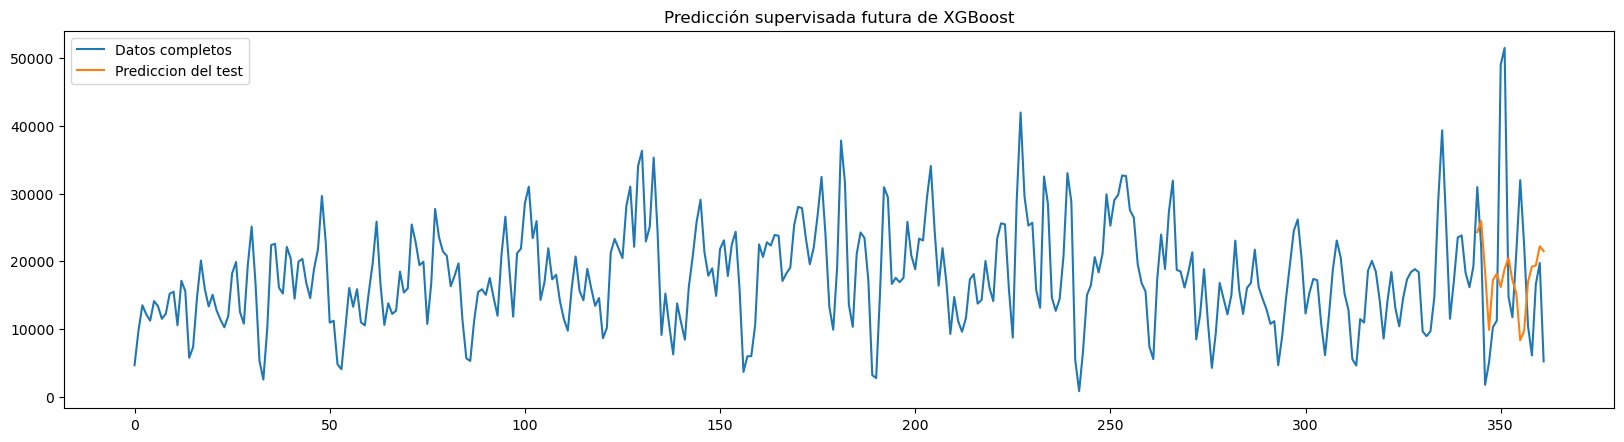

In [71]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset[:, -1])
testPredictPlot[:] = np.nan
# En este caso los datos de predicción tienen que estar desplazados teniendo en cuenta que antes está el train.
testPredictPlot[train_len:len(dataset) + 1] = forecast_list[look_back:]
# plot baseline and predictions
plt.figure(figsize = (20, 5), dpi = 100)
plt.plot(dataset[:, -1], label = 'Datos completos')
plt.plot(testPredictPlot, label = 'Prediccion del test')
plt.title('Predicción supervisada futura de XGBoost')
plt.legend(loc = 'upper left', fontsize = 10)
plt.show()

# =============================================================

### Predicción del modelo dinámico si el COVID no hubiera ocurrido

Se propone una última prueba que sería la situación en la que no se hubiera producido el parón de la pandemia. Cuando los datos eran más constantes, sin los valles ni el pico de recuperación final.

In [40]:
df = df[df.index < '2020-01-01'] # Omitiendo el periodo COVID.

De nuevo el look_back. Se añade una variable booleana para indicarle al código si se desea o no que sea supervisado. En este caso se busca una comprobación menor para comparación, por lo que optimizar el modelo no sería una prioridad.

In [41]:
look_back = 6
supervisado = True

De nuevo los métodos anteriores idénticos, solo que con el nuevo set de datos.

In [42]:
if (supervisado):
    dataset = df.values
    train, test = divide(dataset, proporcion = 0.95)
    forecast_list = np.reshape(train[-look_back:], look_back)
    # Crea la matriz de datos previos como predictores.
    trainXY = series_to_supervised(train, n_in = look_back)
    # split into input and output columns
    trainX, trainY = trainXY[:, :-1], trainXY[:, -1]
    # fit model
    model = XGBRegressor(objective = 'reg:squarederror', n_estimators = 1000)
    model.fit(trainX, trainY)
    train_len = len(train)
    for i in range(len(test)):
        # Realiza la predicción (teniendo solo en cuenta los valores del look_back que influyen en la predicción).
        prediction = model.predict(np.asarray([forecast_list[-look_back:]]))
        # Se añade el dato nuevo de predicción.
        forecast_list = np.append(forecast_list, prediction)

        # En esta parte del for: se va a actualizar el modelo supervisado para encajar los nuevos datos.
        # Al entenamiento antiguo se le añade el dato nuevo predicho.
        train = np.append(train, prediction)
        # Se tienen que establecer los datos en el formato necesario.
        train = np.reshape(train, (len(train), 1))
        # Se adaptan los datos al formato para entrenamiento de train y outcome.
        trainXY = series_to_supervised(train, n_in = look_back)
        # Separa los datos entre train y outcome.
        trainX, trainY = trainXY[:, :-1], trainXY[:, -1]
        # Entrena el modelo.
        model.fit(trainX, trainY)
else:
    dataset = df.values
    train, test = divide(dataset, proporcion = 0.95)
    forecast_list = np.reshape(train[-look_back:], look_back)
    # Crea la matriz de datos previos como predictores.
    trainXY = series_to_supervised(train, n_in = look_back)
    # Se adaptan los datos al formato para entrenamiento de train y outcome.
    trainX, trainY = trainXY[:, :-1], trainXY[:, -1]
    # Fit model con los datos adaptados.
    model = XGBRegressor(objective = 'reg:squarederror', learning_rate = 0.02, n_estimators = 1000)
    model.fit(trainX, trainY)
    for i in range(len(test)):
        prediction = model.predict(np.asarray([forecast_list[-look_back:]]))
        forecast_list = np.append(forecast_list, prediction)

En este caso, la validación ha mostrado un accuracy mejor que en el anterior.

In [43]:
kfold = KFold(n_splits = 10, shuffle = True)
kf_cv_scores = cross_val_score(model, trainX, trainY, cv = kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.27


Aunque la correlación sea notablemente peor, de hecho el error y la autocorrelación han mejorado respecto de los caoss anteriores.

In [44]:
test = np.reshape(test, len(test))
forecast_accuracy(forecast_list[look_back:], test)

D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'mape': 0.346066576598789,
 'me': -4570.676832932692,
 'mae': 7523.633864182692,
 'mpe': -0.05092732274439907,
 'rmse': 10065.64173732092,
 'acf1': 0.6609471729687635,
 'corr': -0.1429591826618569,
 'minmax': 0.276713947018812}

Representación de la predicción.

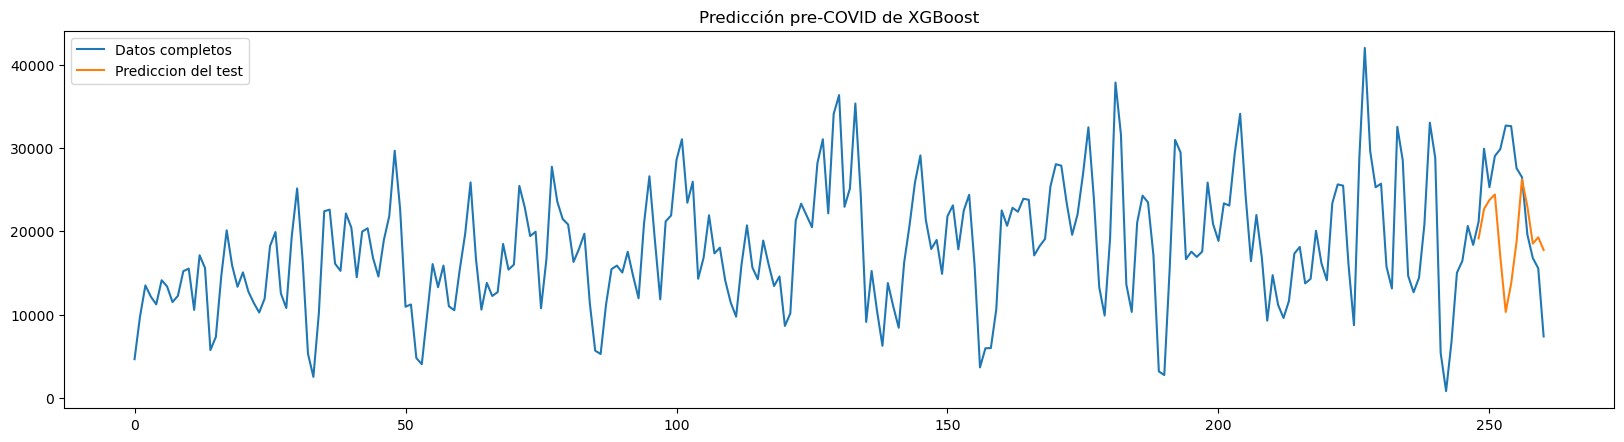

In [45]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset[:, -1])
testPredictPlot[:] = np.nan
# En este caso los datos de predicción tienen que estar desplazados teniendo en cuenta que antes está el train.
if (supervisado):
    testPredictPlot[train_len:len(dataset) + 1] = forecast_list[look_back:]
else:
    testPredictPlot[len(train):len(dataset) + 1] = forecast_list[look_back:]
# plot baseline and predictions
plt.figure(figsize = (20, 5), dpi = 100)
plt.plot(dataset[:, -1], label = 'Datos completos')
plt.plot(testPredictPlot, label = 'Prediccion del test')
plt.title('Predicción pre-COVID de XGBoost')
plt.legend(loc = 'upper left', fontsize = 10)
plt.show()